# Imports

In [47]:
%run PII_Util.py

# Initialize Model Adapter

In [48]:
model_adapter = Yanis_Adapter(threshold = 0.1, checkpoint_path='./fine_tuned/yanis/yanis-02', config_only=True,  mode_bio='reorder')

# Load Data

In [14]:
path_train = './in/train.json'
path_test = './in/test.json'

In [15]:
train_json = json.load(open(path_train))
df_unsplitted = pd.json_normalize(train_json)

test_json = json.load(open(path_test))
df_test = pd.json_normalize(test_json)

In [16]:
df_unsplitted.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


# Split

In [17]:
df_train, df_valid = stratified_split(df_unsplitted, classes, test_size=0.12, random_state=42)

# Preprocessing

In [18]:
from datasets import Dataset

In [19]:
ds_train = Dataset.from_pandas(df_train)
ds_valid = Dataset.from_pandas(df_valid)

In [21]:
%%time
ds_prep_train = ds_train.map(preprocess_from_words, fn_kwargs={"model_adapter": model_adapter, "col_words": "tokens", "col_labels": "labels", "mode_bio": model_adapter.mode_bio}, batched=False)
ds_prep_valid = ds_valid.map(preprocess_from_words, fn_kwargs={"model_adapter": model_adapter, "col_words": "tokens", "col_labels": "labels", "mode_bio": model_adapter.mode_bio}, batched=False)

Map: 100%|███████████████████████████████████████████████████████████████████| 817/817 [00:07<00:00, 111.04 examples/s]

CPU times: total: 1min 19s
Wall time: 1min 28s


# Load Preds

In [23]:
preds_train = np.load("./results/yanis_02/preds_train01.npy")
preds_valid = np.load("./results/yanis_02/preds_valid01.npy")

# Train dataset

In [25]:
np_labels_train = pad_lists(ds_prep_train['labels'], -100, preds_train.shape[1])
threshold = model_adapter.threshold

In [49]:
compute_metrics = functools.partial(compute_metrics_base, preprocessed_dataset=ds_prep_train, model_adapter=model_adapter, threshold=threshold)

In [43]:
train_tup = (preds_train, np_labels_train, None)

In [50]:
%%time
dict_all_scores = compute_metrics(train_tup)

CPU times: total: 53.4 s
Wall time: 53.6 s


In [45]:
model_adapter.config.label2id

{'O': 0,
 'B-EMAIL': 1,
 'B-ID_NUM': 2,
 'B-NAME_STUDENT': 3,
 'B-PHONE_NUM': 4,
 'B-STREET_ADDRESS': 5,
 'B-URL_PERSONAL': 6,
 'B-USERNAME': 7,
 'I-ID_NUM': 8,
 'I-NAME_STUDENT': 9,
 'I-PHONE_NUM': 10,
 'I-STREET_ADDRESS': 11,
 'I-URL_PERSONAL': 12,
 'I-EMAIL': 13,
 'I-USERNAME': 14}

In [51]:
token_confusion_matrix = dict_all_scores.pop('token_confusion_matrix')
word_confusion_matrix = dict_all_scores.pop('word_confusion_matrix')

df_all_metrics = pd.DataFrame(dict_all_scores)

col_id2label = functools.partial(col_id2label_base, model_adapter=model_adapter)
df_all_metrics.columns = df_all_metrics.columns.map(col_id2label)
df_all_metrics = df_all_metrics.T



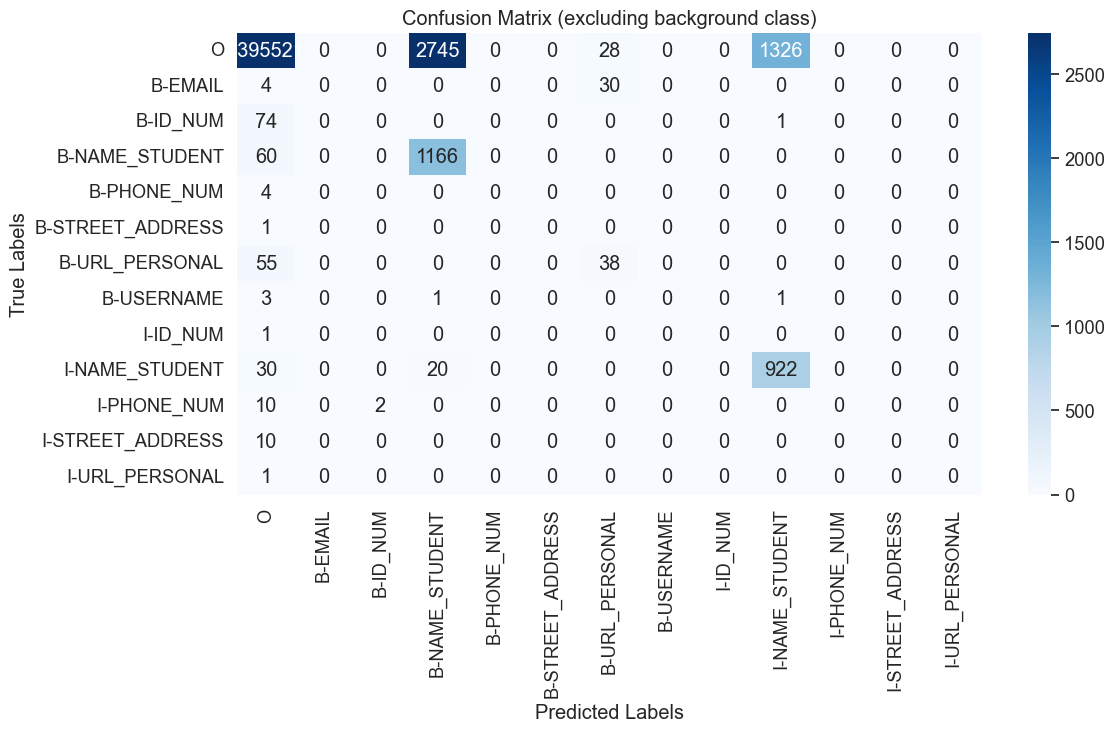

In [53]:
conf_matrix = word_confusion_matrix

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)  # Adjust font scale

# Calculate vmin and vmax excluding the background class
vmin = np.min(conf_matrix[conf_matrix != conf_matrix[0,0]])
vmax = np.max(conf_matrix[conf_matrix != conf_matrix[0,0]])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes, vmin=vmin, vmax=vmax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (excluding background class)')
plt.show()

## Tune Threshold

In [97]:
%%time
threshold = 0.005
compute_metrics = functools.partial(compute_metrics_base, preprocessed_dataset=ds_prep_train, model_adapter=model_adapter, threshold=threshold)
dict_all_scores = compute_metrics(train_tup)

CPU times: total: 59.2 s
Wall time: 1min


In [98]:
token_confusion_matrix = dict_all_scores.pop('token_confusion_matrix')
word_confusion_matrix = dict_all_scores.pop('word_confusion_matrix')

df_all_metrics = pd.DataFrame(dict_all_scores)

col_id2label = functools.partial(col_id2label_base, model_adapter=model_adapter)
df_all_metrics.columns = df_all_metrics.columns.map(col_id2label)
df_all_metrics = df_all_metrics.T

In [100]:
print(f'threshold = {threshold}')
df_all_metrics.loc[['word_total_metrics', 'token_total_metrics']]

threshold = 0.005


,precision,recall,f_beta,tp,fp,fn
word_total_metrics,0.335318,0.879211,0.827582,2140.0,4242.0,294.0
token_total_metrics,0.315113,0.634271,0.610489,3113.0,6766.0,1795.0


In [96]:
print(f'threshold = {threshold}')
df_all_metrics.loc['word_total_metrics']

threshold = 0.01


precision       0.335215
recall          0.878389
f_beta          0.826858
tp           2138.000000
fp           4240.000000
fn            296.000000
Name: word_total_metrics, dtype: float64

In [90]:
print(f'threshold = {threshold}')
df_all_metrics.loc['word_total_metrics']

threshold = 0.05


precision       0.336491
recall          0.875514
f_beta          0.824703
tp           2131.000000
fp           4202.000000
fn            303.000000
Name: word_total_metrics, dtype: float64

In [87]:
%%time
temp_model_adapter = Yanis_Adapter(threshold = 0.1, checkpoint_path='./fine_tuned/yanis-02/best/yanis-02-best', mode_bio='reorder')

CPU times: total: 51.5 s
Wall time: 50.1 s


In [86]:
print(f'threshold = {threshold}')
df_all_metrics.loc['word_total_metrics']

threshold = 0.3


precision       0.345258
recall          0.864421
f_beta          0.817161
tp           2104.000000
fp           3990.000000
fn            330.000000
Name: word_total_metrics, dtype: float64

In [81]:
f_all_metrics.loc['word_total_metrics']

precision       0.354493
recall          0.855793
f_beta          0.811648
tp           2083.000000
fp           3793.000000
fn            351.000000
Name: word_total_metrics, dtype: float64

In [78]:
df_all_metrics.loc['word_total_metrics']

precision       0.338535
recall          0.873459
f_beta          0.823417
tp           2126.000000
fp           4154.000000
fn            308.000000
Name: word_total_metrics, dtype: float64

# Validation dataset

In [59]:
cur_dataset = ds_prep_valid
cur_preds = preds_valid
cur_labels = pad_lists(cur_dataset['labels'], -100, cur_preds.shape[1])


In [60]:
threshold = model_adapter.threshold

In [61]:
compute_metrics = functools.partial(compute_metrics_base, preprocessed_dataset=cur_dataset, model_adapter=model_adapter, threshold=threshold)

In [64]:
tup_results = (cur_preds, cur_labels, None)

In [65]:
%%time
dict_all_scores_valid = compute_metrics(tup_results)

CPU times: total: 6.83 s
Wall time: 6.93 s


In [66]:
token_confusion_matrix_valid = dict_all_scores_valid.pop('token_confusion_matrix')
word_confusion_matrix_valid = dict_all_scores_valid.pop('word_confusion_matrix')

df_all_metrics_valid = pd.DataFrame(dict_all_scores)

col_id2label = functools.partial(col_id2label_base, model_adapter=model_adapter)
df_all_metrics_valid.columns = df_all_metrics_valid.columns.map(col_id2label)
df_all_metrics_valid = df_all_metrics_valid.T



In [67]:
df_all_metrics_valid

,precision,recall,f_beta,tp,fp,fn
token_total_metrics,0.319263,0.621027,0.599242,3048.0,6499.0,1860.0
word_total_metrics,0.338535,0.873459,0.823417,2126.0,4154.0,308.0
token_O,0.999601,0.998540,0.998581,4165064.0,1662.0,6088.0
token_B-EMAIL,0.000000,0.000000,0.000000,0.0,0.0,32.0
token_B-ID_NUM,0.500000,0.093333,0.096347,7.0,7.0,68.0
token_B-NAME_STUDENT,0.278946,0.942041,0.863126,1154.0,2983.0,71.0
token_B-PHONE_NUM,0.000000,0.000000,0.000000,0.0,0.0,4.0
token_B-STREET_ADDRESS,0.000000,0.000000,0.000000,0.0,0.0,1.0
token_B-URL_PERSONAL,0.004132,0.022727,0.019374,2.0,482.0,86.0
token_B-USERNAME,0.000000,0.000000,0.000000,0.0,0.0,5.0


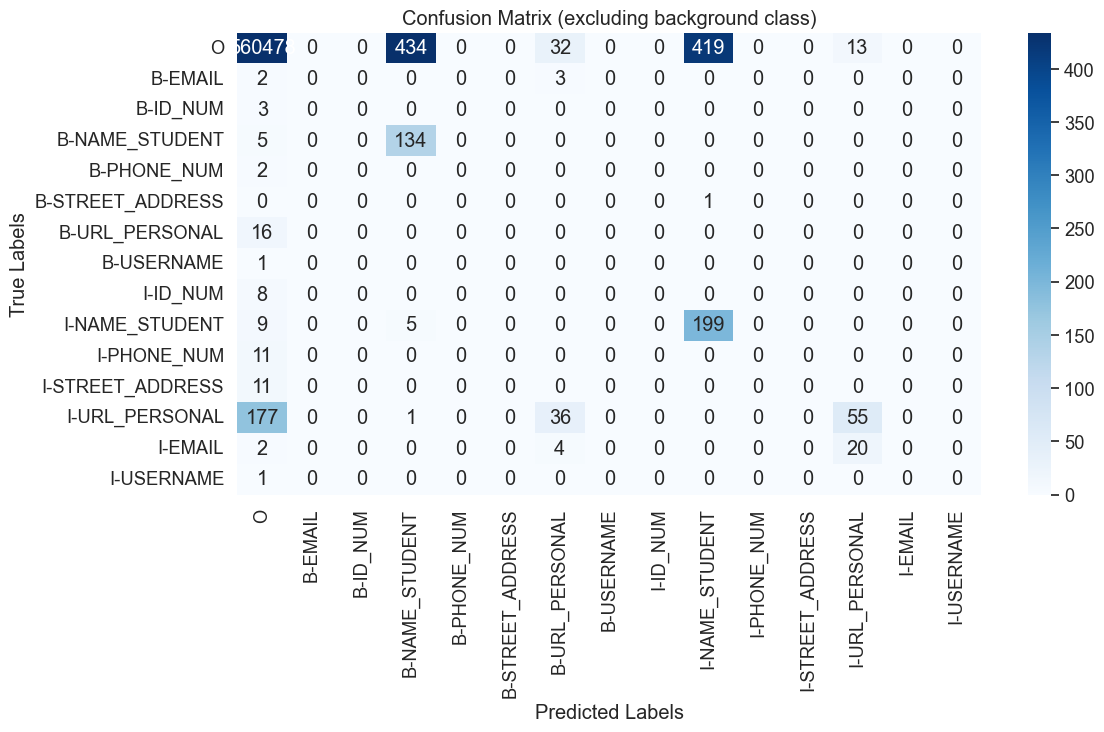

In [68]:
conf_matrix = token_confusion_matrix_valid

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)  # Adjust font scale

# Calculate vmin and vmax excluding the background class
vmin = np.min(conf_matrix[conf_matrix != conf_matrix[0,0]])
vmax = np.max(conf_matrix[conf_matrix != conf_matrix[0,0]])

ticklabels = [clas for clas,i in model_adapter.config.label2id.items()]


sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=ticklabels, yticklabels=ticklabels, vmin=vmin, vmax=vmax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (excluding background class)')
plt.show()

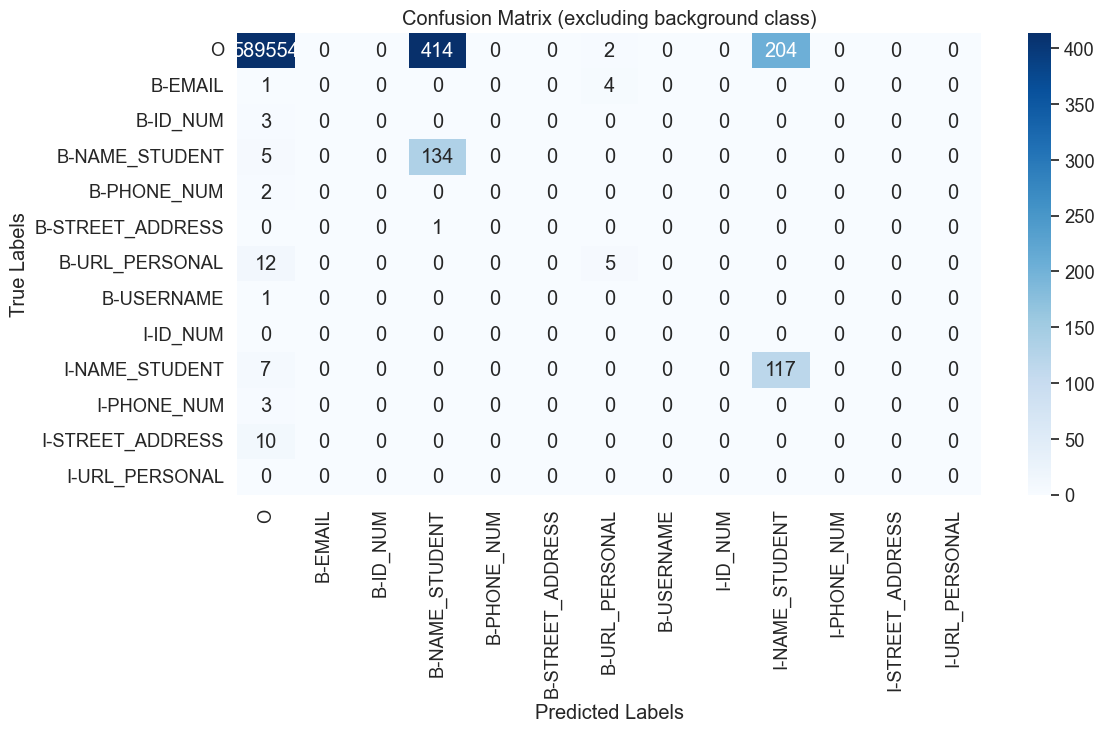

In [69]:
conf_matrix = word_confusion_matrix_valid

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)  # Adjust font scale

# Calculate vmin and vmax excluding the background class
vmin = np.min(conf_matrix[conf_matrix != conf_matrix[0,0]])
vmax = np.max(conf_matrix[conf_matrix != conf_matrix[0,0]])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes, vmin=vmin, vmax=vmax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (excluding background class)')
plt.show()

# Test Set 

In [71]:
df_test

,document,full_text,tokens,trailing_whitespace
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal..."
5,86,Cheese Startup - Learning Launch ​by Eladio Am...,"[Cheese, Startup, -, Learning, Launch, ​by, El...","[True, True, True, True, True, True, True, Fal..."
6,93,Silvia Villalobos\n\nChallenge:\n\nThere is a ...,"[Silvia, Villalobos, \n\n, Challenge, :, \n\n,...","[True, False, False, False, False, False, True..."
7,104,Storytelling The Path to Innovation\n\nDr Sak...,"[Storytelling, , The, Path, to, Innovation, \...","[True, False, True, True, True, False, False, ..."
8,112,Reflection – Learning Launch\n\nFrancisco Ferr...,"[Reflection, –, Learning, Launch, \n\n, Franci...","[True, True, True, False, False, True, False, ..."
9,123,Gandhi Institute of Technology and Management ...,"[Gandhi, Institute, of, Technology, and, Manag...","[True, True, True, True, True, True, False, Tr..."


In [70]:
# ds_test = Dataset.from_pandas(df_test)
# ds_prep_test = ds_test.map(preprocess_from_words, fn_kwargs={"model_adapter": model_adapter, "col_words": "tokens", "col_labels": "labels", "mode_bio": model_adapter.mode_bio}, batched=False)

Map:   0%|                                                                               | 0/10 [00:00<?, ? examples/s]


KeyError: 'labels'